In [8]:
# 对高频因子进行降频处理

In [9]:
import pandas as pd
import numpy as np

In [10]:
z = pd.read_hdf('/Users/aming/project/python/课程代码合集/高频因子的思考和设计_2/data/jm2401.h5')

In [11]:
# 計算odb因子
def orderbook_imbalance(z:pd.DataFrame,n:int = 3) -> pd.Series:
    '''订单薄失衡'''
    # 计算bid一侧
    bid_p_previous = z[f'bp1'].shift(1)
    bid_p_current = z[f'bp1']
    # 当前bid price大于上一刻的bid price,增量为当前的挂单量也就是bid_v
    delta_v1 = (bid_p_current > bid_p_previous) * z['bv1']
    # 当前bid price小于上一刻的bid price,增量为前一刻被成交的量取负数
    delta_v2 = (bid_p_current < bid_p_previous) * z['bv1'].shift(1) * -1.
    # 当前bid price等于上一刻的bid price,增量为当前的挂单量减去前一刻的挂单量
    delta_v3 = (bid_p_current == bid_p_previous) * (z['bv1'] - z['bv1'].shift(1))
    # 三者相加，得到最终的delta_v
    delta_bid_v = delta_v1 + delta_v2 + delta_v3

    # 计算ask一侧
    ask_p_previous = z['ap1'].shift(1)
    ask_p_current = z['ap1']
    # 当前ask price大于上一刻的ask price,增量为前一刻被成交量取负数
    delta_v1 = (ask_p_current > ask_p_previous) * z['av1'].shift(1) * -1.
    # 当前aid price小于上一刻的aid price,增量为当前的挂单量也就是bid_v
    delta_v2 = (ask_p_current < ask_p_previous) * z['av1']
    # 当前ask price等于上一刻的ask price,增量为当前的挂单量减去前一刻的挂单量
    delta_v3 = (ask_p_current == ask_p_previous) * (z['av1'] - z['av1'].shift(1))
    # 三者相加，得到最终的delta_v
    
    # (新的高价买单进入 → 买方积极)  + (原有买单被消耗 → 买方力量减弱) + (同价位挂单变化 → 直接计算差值)
    delta_ask_v = delta_v1 + delta_v2 + delta_v3

    orderbook_imbalance_factor = delta_bid_v - delta_ask_v

    return orderbook_imbalance_factor

In [12]:
odb_imb = orderbook_imbalance(z)

In [13]:
odb_imb

time
2023-09-04 08:59:00.009     NaN
2023-09-04 09:00:00.357    10.0
2023-09-04 09:00:00.851     7.0
2023-09-04 09:00:01.356    -3.0
2023-09-04 09:00:01.835     7.0
                           ... 
2023-09-27 22:59:58.170   -13.0
2023-09-27 22:59:58.678    -6.0
2023-09-27 22:59:59.160   -14.0
2023-09-27 22:59:59.663    17.0
2023-09-27 23:00:00.029    -1.0
Length: 644454, dtype: float64

In [14]:
# 滚动标准化z-score
import talib as ta
mean_ = ta.MA(odb_imb,2000)
std_ = ta.STDDEV(odb_imb,2000)
# 减去均值是做中心化处理，让因子值围绕均值分布。
# 除以标准差是为了缩放
(odb_imb-mean_)/std_

time
2023-09-04 08:59:00.009         NaN
2023-09-04 09:00:00.357         NaN
2023-09-04 09:00:00.851         NaN
2023-09-04 09:00:01.356         NaN
2023-09-04 09:00:01.835         NaN
                             ...   
2023-09-27 22:59:58.170   -1.067278
2023-09-27 22:59:58.678   -0.511624
2023-09-27 22:59:59.160   -1.145878
2023-09-27 22:59:59.663    1.313759
2023-09-27 23:00:00.029   -0.114499
Length: 644454, dtype: float64

<Axes: >

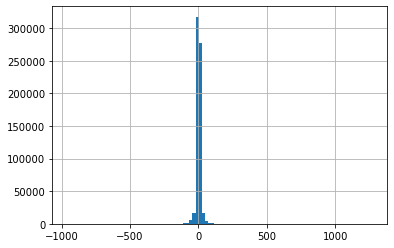

In [15]:
# 因子要不要做處理？
# 觀察因子的分佈情況
odb_imb.hist(bins=100)

In [16]:
odb_imb.describe()

count    644453.000000
mean         -0.022439
std          16.725068
min        -957.000000
25%          -3.000000
50%           0.000000
75%           3.000000
max        1270.000000
dtype: float64

In [17]:
max_value=odb_imb.quantile(0.95)
min_value=odb_imb.quantile(0.05)
print("95%分位值:", max_value)
print("-95%分位值:",min_value)

95%分位值: 18.0
-95%分位值: -19.0


In [18]:
# 对因子进行裁剪
clipped_ = odb_imb.clip(min_value,max_value)

In [19]:
clipped_

time
2023-09-04 08:59:00.009     NaN
2023-09-04 09:00:00.357    10.0
2023-09-04 09:00:00.851     7.0
2023-09-04 09:00:01.356    -3.0
2023-09-04 09:00:01.835     7.0
                           ... 
2023-09-27 22:59:58.170   -13.0
2023-09-27 22:59:58.678    -6.0
2023-09-27 22:59:59.160   -14.0
2023-09-27 22:59:59.663    17.0
2023-09-27 23:00:00.029    -1.0
Length: 644454, dtype: float64

In [20]:
# index必须是时间戳，label
resampled_clipped = clipped_.iloc[1:].resample('1s',label='right').aggregate('sum')

In [21]:
resampled_clipped

time
2023-09-04 09:00:01    17.0
2023-09-04 09:00:02     4.0
2023-09-04 09:00:03    20.0
2023-09-04 09:00:04    10.0
2023-09-04 09:00:05     0.0
                       ... 
2023-09-27 22:59:57   -20.0
2023-09-27 22:59:58   -24.0
2023-09-27 22:59:59   -19.0
2023-09-27 23:00:00     3.0
2023-09-27 23:00:01    -1.0
Freq: S, Length: 2037601, dtype: float64

In [22]:
# 对订单薄数据做降采样处理
z
# 根据切片之间的情况，对切片之间的这笔交易做了一个标记。
# 持仓量和价格的联动关系来决定，此时这笔交易属于什么性质
# 持仓量上升&价格上升&主买，多开 

,bp1,bv1,ap1,av1,p,v,a,oi,type
time,,,,,,,,,
2023-09-04 08:59:00.009,1680.0,274,1680.5,6,1680.0,252,25401600,187905,3
2023-09-04 09:00:00.357,1681.5,4,1683.0,6,1683.0,125,12610860,187928,3
2023-09-04 09:00:00.851,1683.5,1,1685.0,47,1684.5,165,16663320,187889,5
2023-09-04 09:00:01.356,1683.5,2,1684.5,4,1684.5,73,7376160,187856,5
2023-09-04 09:00:01.835,1684.5,3,1685.0,2,1683.5,121,12227490,187867,4
...,...,...,...,...,...,...,...,...,...
2023-09-27 22:59:58.170,1861.0,28,1862.0,6,1862.0,24,2680800,179386,5
2023-09-27 22:59:58.678,1861.0,25,1861.5,3,1861.0,7,781770,179383,6
2023-09-27 22:59:59.160,1861.0,14,1861.5,6,1861.0,16,1786710,179383,8


In [23]:
resampled_z = z.iloc[1:].resample('1s',label='right').aggregate({'bp1':'last',
                                                  'bv1':'last',
                                                  'ap1':'last',
                                                  'av1':'last',
                                                  'p':'last',
                                                  'v':'sum',
                                                  'a':'sum',
                                                  'oi':'last',
                                                  'type':'last'})

In [24]:
# 怎么用odb因子？降频前vs降频后
resampled_z

,bp1,bv1,ap1,av1,p,v,a,oi,type
time,,,,,,,,,
2023-09-04 09:00:01,1683.5,1.0,1685.0,47.0,1684.5,290,29274180,187889.0,5.0
2023-09-04 09:00:02,1684.5,3.0,1685.0,2.0,1683.5,194,19603650,187867.0,4.0
2023-09-04 09:00:03,1684.5,23.0,1685.5,3.0,1684.5,192,19418550,187790.0,6.0
2023-09-04 09:00:04,1685.5,1.0,1686.5,9.0,1685.5,73,7383210,187773.0,6.0
2023-09-04 09:00:05,1685.0,31.0,1685.5,8.0,1685.0,174,17598660,187771.0,6.0
...,...,...,...,...,...,...,...,...,...
2023-09-27 22:59:57,1862.0,12.0,1862.5,14.0,1862.0,29,3240030,179395.0,4.0
2023-09-27 22:59:58,1861.5,15.0,1862.0,8.0,1861.5,46,5139570,179394.0,6.0
2023-09-27 22:59:59,1861.0,25.0,1861.5,3.0,1861.0,31,3462570,179383.0,6.0


In [25]:
midprice = (resampled_z['bp1']+resampled_z['ap1'])/2

In [26]:
# 在降频后的订单薄数据上加上一列————未来一个周期的收益率
resampled_z['ret_1'] = midprice.shift(-1)/midprice - 1
resampled_z['ret_3'] = midprice.shift(-3)/midprice - 1
resampled_z['ret_5'] = midprice.shift(-5)/midprice - 1
resampled_z['ret_10'] = midprice.shift(-10)/midprice - 1
resampled_z['ret_15'] = midprice.shift(-15)/midprice - 1
resampled_z['ret_30'] = midprice.shift(-15)/midprice - 1

In [27]:
resampled_z
# 更严格的做法，收益率也是要做标准化的，ret_3/根号3

,bp1,bv1,ap1,av1,p,v,a,oi,type,ret_1,ret_3,ret_5,ret_10,ret_15,ret_30
time,,,,,,,,,,,,,,,
2023-09-04 09:00:01,1683.5,1.0,1685.0,47.0,1684.5,290,29274180,187889.0,5.0,0.000297,0.001039,0.000891,-0.001484,-0.000297,-0.000297
2023-09-04 09:00:02,1684.5,3.0,1685.0,2.0,1683.5,194,19603650,187867.0,4.0,0.000148,0.000297,0.000890,-0.001929,-0.000890,-0.000890
2023-09-04 09:00:03,1684.5,23.0,1685.5,3.0,1684.5,192,19418550,187790.0,6.0,0.000593,0.000445,-0.000445,-0.001632,-0.001632,-0.001632
2023-09-04 09:00:04,1685.5,1.0,1686.5,9.0,1685.5,73,7383210,187773.0,6.0,-0.000445,0.000148,-0.001335,-0.001631,-0.002224,-0.002224
2023-09-04 09:00:05,1685.0,31.0,1685.5,8.0,1685.0,174,17598660,187771.0,6.0,0.000297,-0.000593,-0.001038,-0.000890,-0.001335,-0.001335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-27 22:59:57,1862.0,12.0,1862.5,14.0,1862.0,29,3240030,179395.0,4.0,-0.000268,-0.000537,NaN,NaN,NaN,NaN
2023-09-27 22:59:58,1861.5,15.0,1862.0,8.0,1861.5,46,5139570,179394.0,6.0,-0.000269,-0.000269,NaN,NaN,NaN,NaN
2023-09-27 22:59:59,1861.0,25.0,1861.5,3.0,1861.0,31,3462570,179383.0,6.0,0.000000,NaN,NaN,NaN,NaN,NaN


In [28]:
# 看看降频后的因子和收益率的ic decay?
# 对未来收益率的预测周期越长越好，因子的稳定性越好
resampled_clipped


time
2023-09-04 09:00:01    17.0
2023-09-04 09:00:02     4.0
2023-09-04 09:00:03    20.0
2023-09-04 09:00:04    10.0
2023-09-04 09:00:05     0.0
                       ... 
2023-09-27 22:59:57   -20.0
2023-09-27 22:59:58   -24.0
2023-09-27 22:59:59   -19.0
2023-09-27 23:00:00     3.0
2023-09-27 23:00:01    -1.0
Freq: S, Length: 2037601, dtype: float64

In [29]:
ic_decay_list = []
for i in resampled_z.columns[9:]:
    ic_decay_list.append(resampled_clipped.corr(resampled_z[i]))
print(ic_decay_list)

[0.12310880332485911, 0.12512420952964787, 0.12136171977875258, 0.0986608337043087, 0.08226497082554365, 0.08226497082554365]


In [30]:
ic_decay_list

[0.12310880332485911,
 0.12512420952964787,
 0.12136171977875258,
 0.0986608337043087,
 0.08226497082554365,
 0.08226497082554365]

<Axes: >

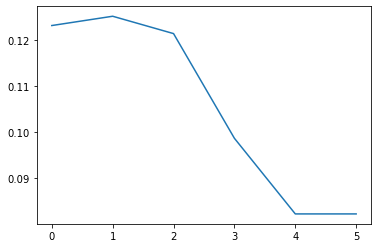

In [31]:
pd.Series(ic_decay_list).plot()
# ic decay怎么看？

In [32]:
# 查看滚动窗口的ic变化情况
import talib as ta
rolling_ic = ta.CORREL(resampled_z['ret_5'].fillna(0),resampled_clipped,50000)

<Axes: xlabel='time'>

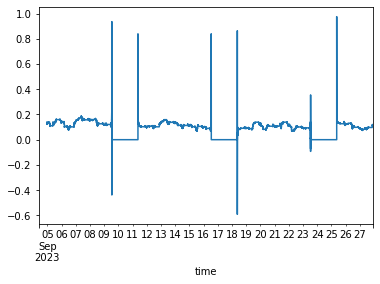

In [33]:
rolling_ic.plot()

<Axes: >

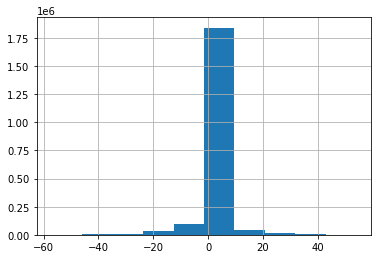

In [34]:
# 由ic decay图可知，因子和5个周期的收益率相关性最强
# 接下来我们看看把因子值视作仓位，在5个周期上的盈利能
resampled_clipped.hist()

In [35]:
position = resampled_clipped/100

In [36]:
position.describe()

count    2.037601e+06
mean    -1.157685e-04
std      4.989592e-02
min     -5.700000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.400000e-01
dtype: float64

<Axes: >

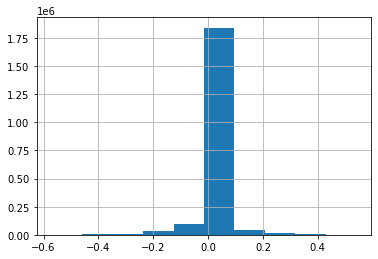

In [37]:
position.hist()

In [38]:
net_value = 1+(position*resampled_z['ret_5'].fillna(0)).cumsum()

<Axes: xlabel='time'>

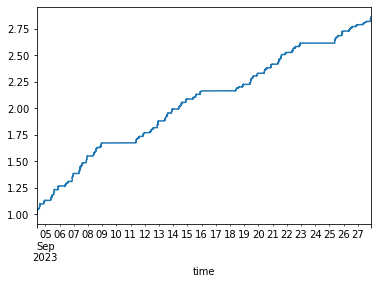

In [39]:
net_value.plot()
# 说明这个因子的盈亏比非常好

In [40]:
spread = np.mean(z.ap1-z.bp1)

In [41]:
spread

0.5835777262613002

In [42]:
# 那么我们扣掉手续费呢
net_value_after_fee = 1+(position*resampled_z['ret_5'].fillna(0)*0.9996).cumsum()


In [43]:
net_value_after_fee

time
2023-09-04 09:00:01    1.000151
2023-09-04 09:00:02    1.000187
2023-09-04 09:00:03    1.000098
2023-09-04 09:00:04    0.999965
2023-09-04 09:00:05    0.999965
                         ...   
2023-09-27 22:59:57    2.861620
2023-09-27 22:59:58    2.861620
2023-09-27 22:59:59    2.861620
2023-09-27 23:00:00    2.861620
2023-09-27 23:00:01    2.861620
Freq: S, Length: 2037601, dtype: float64

<Axes: xlabel='time'>

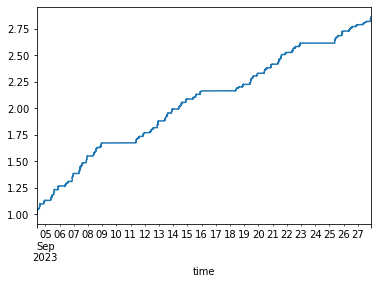

In [44]:
net_value_after_fee.plot()


In [45]:
# 如果扣除滑点成本呢？
net_value_after_fee_and_spread = 1+(position*resampled_z['ret_5'].fillna(0)*0.9996-spread).cumsum()




In [46]:
net_value_after_fee_and_spread

time
2023-09-04 09:00:01    4.165736e-01
2023-09-04 09:00:02   -1.669685e-01
2023-09-04 09:00:03   -7.506352e-01
2023-09-04 09:00:04   -1.334346e+00
2023-09-04 09:00:05   -1.917924e+00
                           ...     
2023-09-27 22:59:57   -1.189093e+06
2023-09-27 22:59:58   -1.189094e+06
2023-09-27 22:59:59   -1.189095e+06
2023-09-27 23:00:00   -1.189095e+06
2023-09-27 23:00:01   -1.189096e+06
Freq: S, Length: 2037601, dtype: float64

<Axes: xlabel='time'>

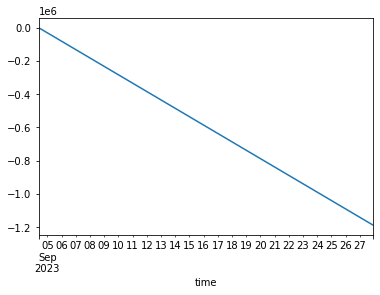

In [47]:
# 滑点比手续费更吃利润
net_value_after_fee_and_spread.plot()

<Axes: >

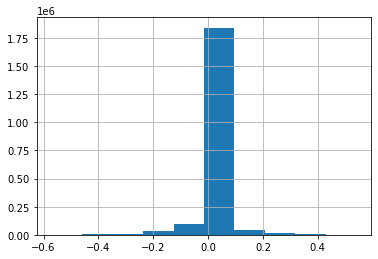

In [48]:
# 优化方向一：只在因子大于一定阈值时才开仓(开仓)
position.hist()

In [49]:
binning_position = ((position>0.5)&(position<-0.5))*position

In [50]:
print(position)

time
2023-09-04 09:00:01    0.17
2023-09-04 09:00:02    0.04
2023-09-04 09:00:03    0.20
2023-09-04 09:00:04    0.10
2023-09-04 09:00:05    0.00
                       ... 
2023-09-27 22:59:57   -0.20
2023-09-27 22:59:58   -0.24
2023-09-27 22:59:59   -0.19
2023-09-27 23:00:00    0.03
2023-09-27 23:00:01   -0.01
Freq: S, Length: 2037601, dtype: float64


<Axes: >

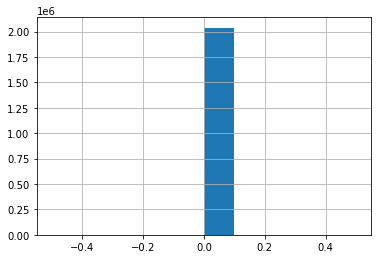

In [51]:
binning_position.hist()

In [52]:
# 分箱后扣除滑点成本呢？
net_value_after_binning = 1+((binning_position!=0)*binning_position*resampled_z['ret_5'].fillna(0)*0.9996-spread).cumsum()

In [53]:
net_value_after_binning

time
2023-09-04 09:00:01    4.164223e-01
2023-09-04 09:00:02   -1.671555e-01
2023-09-04 09:00:03   -7.507332e-01
2023-09-04 09:00:04   -1.334311e+00
2023-09-04 09:00:05   -1.917889e+00
                           ...     
2023-09-27 22:59:57   -1.189095e+06
2023-09-27 22:59:58   -1.189096e+06
2023-09-27 22:59:59   -1.189096e+06
2023-09-27 23:00:00   -1.189097e+06
2023-09-27 23:00:01   -1.189098e+06
Freq: S, Length: 2037601, dtype: float64

<Axes: xlabel='time'>

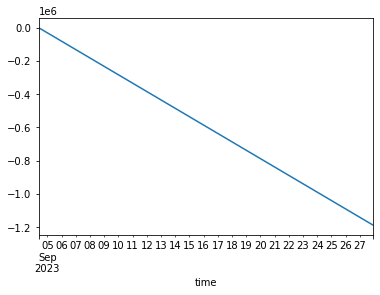

In [54]:
net_value_after_binning.plot()

In [55]:
# 优化方向二：打单变挂单
list_price = (position>0)*resampled_z.bp1 + (position<0)*resampled_z.ap1 

In [56]:
# 假设挂单可以成交，那么
ret_5 = midprice.shift(-5)/list_price-1

In [57]:
net_value_after_fee_and_spread_buylist = 1+(ret_5.fillna(0)*position*0.9996-spread).cumsum()

In [58]:
net_value_after_fee_and_spread_buylist

time
2023-09-04 09:00:01    4.166494e-01
2023-09-04 09:00:02   -1.668868e-01
2023-09-04 09:00:03   -7.504942e-01
2023-09-04 09:00:04   -1.334176e+00
2023-09-04 09:00:05             NaN
                           ...     
2023-09-27 22:59:57   -1.177923e+06
2023-09-27 22:59:58   -1.177923e+06
2023-09-27 22:59:59   -1.177924e+06
2023-09-27 23:00:00   -1.177924e+06
2023-09-27 23:00:01   -1.177925e+06
Freq: S, Length: 2037601, dtype: float64

<Axes: xlabel='time'>

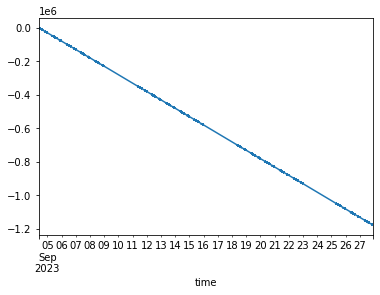

In [59]:
# 挂单是否能成交？
# 跟随信号调整挂撤单
net_value_after_fee_and_spread_buylist.plot()